# Differential expression analysis and marker identification for cross-disease monocyte-derived macrophage analysis:

import modules:

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
%load_ext lab_black

In [3]:
# Functions
def make_title(x):
    return (
        x.replace("_", " ")
        .lower()
        .capitalize()
        .replace("covid", "COVID-19")
        .replace("Balf", "BALF")
    )

set paths:

In [4]:
path_adata_mdm = (
    "../../data/HLCA_extended/extension_disease/scarches_emb_MdM_full-matrix.h5ad"
)
dir_figures = "../../results/figures/"
dir_differential_expr_analysis = "../../results/DEAs/MDM_clusters/"

load data:

In [5]:
adata_mdm = sc.read_h5ad(path_adata_mdm)

set figure parameters:

In [6]:
sc.set_figure_params(figsize=(4, 4))

create empty dict for figures:

In [7]:
FIGURES = dict()

## Differential gene expression analysis:

Print number of cells per cluster (has to be included in the manuscript as we do statistical tests on the clusters)

In [8]:
adata_mdm.obs["leiden_0.3"].value_counts()

0    64915
1    47539
2    32027
3    31097
4    25267
5     1998
6      307
Name: leiden_0.3, dtype: int64

Reduce genes: filter out genes expressed in few cells or genes expressed in a single dataset.

Filtering out genes detected inf ewer than 20 cells:

In [9]:
adata_mdm.shape  # shape before basic filter

(203150, 59586)

In [10]:
sc.pp.filter_genes(adata_mdm, min_cells=20)

In [11]:
adata_mdm.shape

(203150, 32368)

filter out dataset-specific genes, using groupby:

In [12]:
adata_mdm_genedf = pd.DataFrame(
    adata_mdm.X.toarray(), index=adata_mdm.obs.index, columns=adata_mdm.var.index
)

In [13]:
genes = adata_mdm_genedf.columns

In [14]:
adata_mdm_genedf["study"] = adata_mdm.obs["study"]

In [15]:
genedf_study = adata_mdm_genedf.groupby("study").agg({gene: "sum" for gene in genes})

In [16]:
gene_in_multiple_studies = (genedf_study > 0).sum(axis=0) > 1
gene_in_multiple_studies = gene_in_multiple_studies.loc[
    gene_in_multiple_studies.values
].index.tolist()

Number of genes found in multiple studies:

In [17]:
len(gene_in_multiple_studies)

27810

Now filter the adata object:

In [18]:
adata_mdm_filt = adata_mdm[:, gene_in_multiple_studies].copy()

Set uns['log1p'] to prevent scanpy bug in the differential expression analysis:

In [19]:
adata_mdm_filt.uns["log1p"]["base"] = None

Now perform differential expression analysis per cluster:

In [20]:
sc.tl.rank_genes_groups(adata_mdm_filt, groupby="leiden_0.3", method="wilcoxon")

And filter, such that we exclude genes highly expressed in out-group clusters, and genes lowly expressed in in-group cluster:

In [21]:
sc.tl.filter_rank_genes_groups(
    adata_mdm_filt,
    key="rank_genes_groups",
    key_added="rank_genes_groups_filtered",
    min_in_group_fraction=0.3,
    max_out_group_fraction=0.2,
)

Store results in dictionary (all differentially expressed genes that passed filtering, and the top 15 in a separate dictionary) for figures further down.

In [22]:
# extract degs per cluster:
degs_per_cluster = dict()
degs_top15_per_cluster = dict()
for cluster in range(0, 7):
    degs_per_cluster[cluster] = sc.get.rank_genes_groups_df(
        adata_mdm_filt,
        group=str(cluster),
        pval_cutoff=0.05,
        # log2fc_max=,
        key="rank_genes_groups_filtered",
    ).dropna(axis=0, how="any")
    n_genes_total = degs_per_cluster[cluster].shape[0]
    degs_top15_per_cluster[str(cluster)] = (
        degs_per_cluster[cluster].names[: min(15, n_genes_total)].tolist()
    )
    print(f"Cluster {cluster}: n genes={n_genes_total}.")

Cluster 0: n genes=58.
Cluster 1: n genes=147.
Cluster 2: n genes=47.
Cluster 3: n genes=26.
Cluster 4: n genes=34.
Cluster 5: n genes=52.
Cluster 6: n genes=10.


## Figures:

Generate variables that includes information about both cluster + study, and condition + study. To prevent overcrowding of plots later on, and noise due to sparsity in low-abundance groups, set all groups (cluster + study) that have fewer than 200 cells to "Other" for each cluster:

In [23]:
for i in ["leiden_0.3", "condition_merged"]:
    adata_mdm_filt.obs[i + "_study"] = [
        f"{cl} ({st})"
        for cl, st in zip(adata_mdm_filt.obs[i], adata_mdm_filt.obs["study"])
    ]
    leid_st_value_counts = adata_mdm_filt.obs[i + "_study"].value_counts()
    lei_st_mapping = {gr: gr for gr in adata_mdm_filt.obs[i + "_study"].unique()}
    min_n_cells = 200
    for gr in leid_st_value_counts.loc[leid_st_value_counts < min_n_cells].index:
        lei_st_mapping[gr] = f"{gr[:1]} (Other)"
    adata_mdm_filt.obs[i + "_study"] = (
        adata_mdm_filt.obs[i + "_study"].map(lei_st_mapping).astype("category")
    )

Also styling the sample type variable labels

In [24]:
adata_mdm_filt.obs["sample_type"].value_counts()
adata_mdm_filt.obs["sample_type"] = pd.Categorical(
    [make_title(i) for i in adata_mdm_filt.obs["sample_type"]]
)
adata_mdm_filt.obs["sample_type"].value_counts()

Lung explant                63788
Donor lung                  62505
BALF                        26180
Autopsy                     25362
Surgical resection          11677
BALF cryopreserved           8347
Donor lung cryopreserved     3945
Brush                         673
Autopsy cryopreserved         440
Scraping                      227
Biopsy                          6
Name: sample_type, dtype: int64

Fetching colours

In [25]:
obs_cond = [
    "condition",
    "study",
    "sample_type",
    "condition_merged_study",
]
condition_colors = {i: {} for i in obs_cond}
defined = {
    "Healthy": "#e4e4e4",
    "COVID-19": "red",
    "IPF": "orange",
    "Pneumonia non-COVID": "#087819",
}
for obs_i in obs_cond:
    print(f"Colouring: {obs_i}")
    if len(adata_mdm_filt.obs[obs_i].cat.categories) > 20:
        if len(adata_mdm_filt.obs[obs_i].cat.categories) > 28:
            temp = sc.plotting.palettes.godsnot_102
        else:
            temp = sc.plotting.palettes.zeileis_28
    else:
        temp = sc.plotting.palettes.default_20  # list(mpl.rcParams["axes.prop_cycle"])
    for i, v in enumerate(adata_mdm_filt.obs[obs_i].cat.categories):
        if v in defined.keys():
            condition_colors[obs_i][v] = defined[v]
        else:
            condition_colors[obs_i][v] = temp[i]
condition_colors["condition_merged"] = condition_colors["condition"]
condition_colors["condition_merged"]["Carcinoma"] = "#b3ae34"
condition_colors["condition_merged"]["Other diseases"] = "#8c8c8c"

Colouring: condition
Colouring: study
Colouring: sample_type
Colouring: condition_merged_study


Giving studies their colours in condition_merged_study

In [26]:
for i in condition_colors["condition_merged_study"].keys():
    for j in condition_colors["study"].keys():
        if j in i:
            condition_colors["condition_merged_study"][i] = condition_colors["study"][j]

Plot general monocyte and macrophage subtype markers, to see if these are really MDMs:

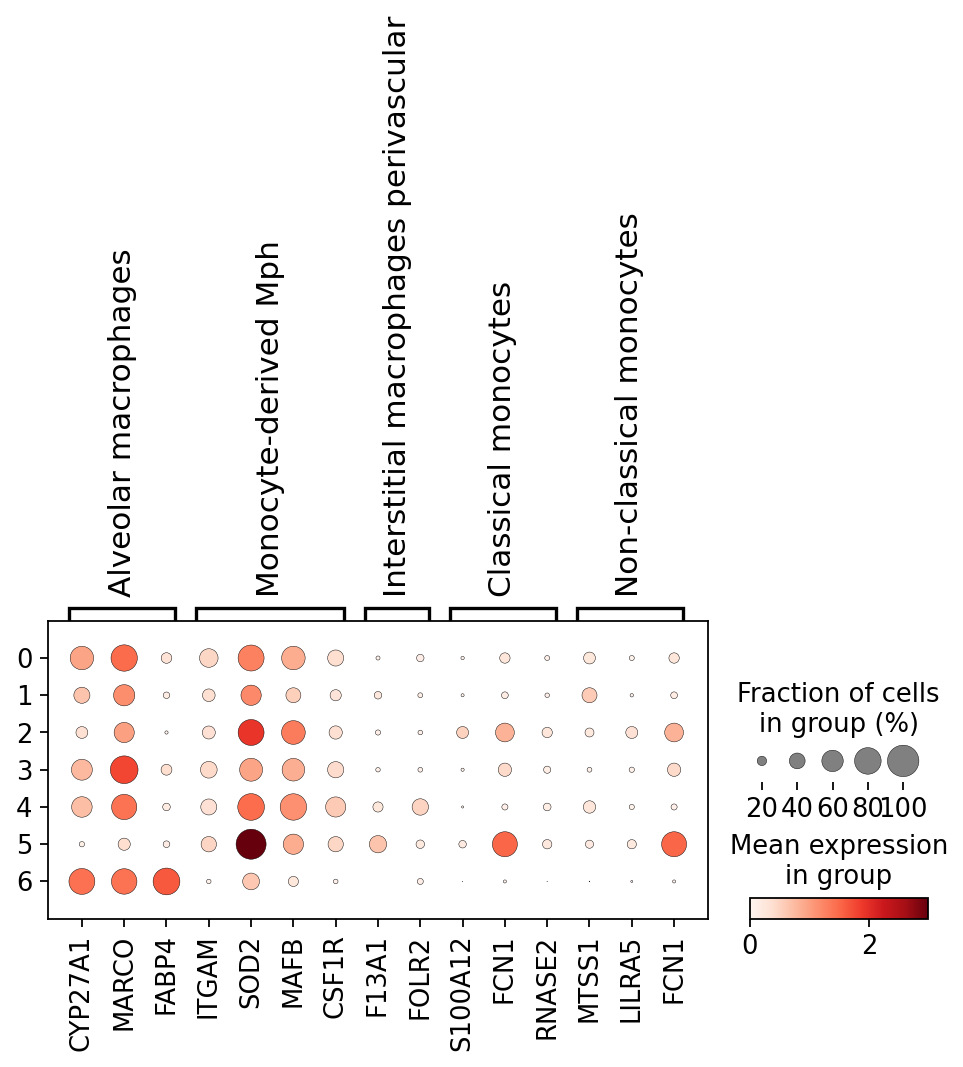

In [27]:
sc.pl.dotplot(
    adata_mdm,
    var_names={
        "Alveolar macrophages": ["CYP27A1", "MARCO", "FABP4"],
        "Monocyte-derived Mph": ["ITGAM", "SOD2", "MAFB", "CSF1R"],
        "Interstitial macrophages perivascular": ["F13A1", "FOLR2"],
        "Classical monocytes": ["S100A12", "FCN1", "RNASE2"],
        "Non-classical monocytes": ["MTSS1", "LILRA5", "FCN1"],
    },
    groupby="leiden_0.3",
)

Plot results of DEA:

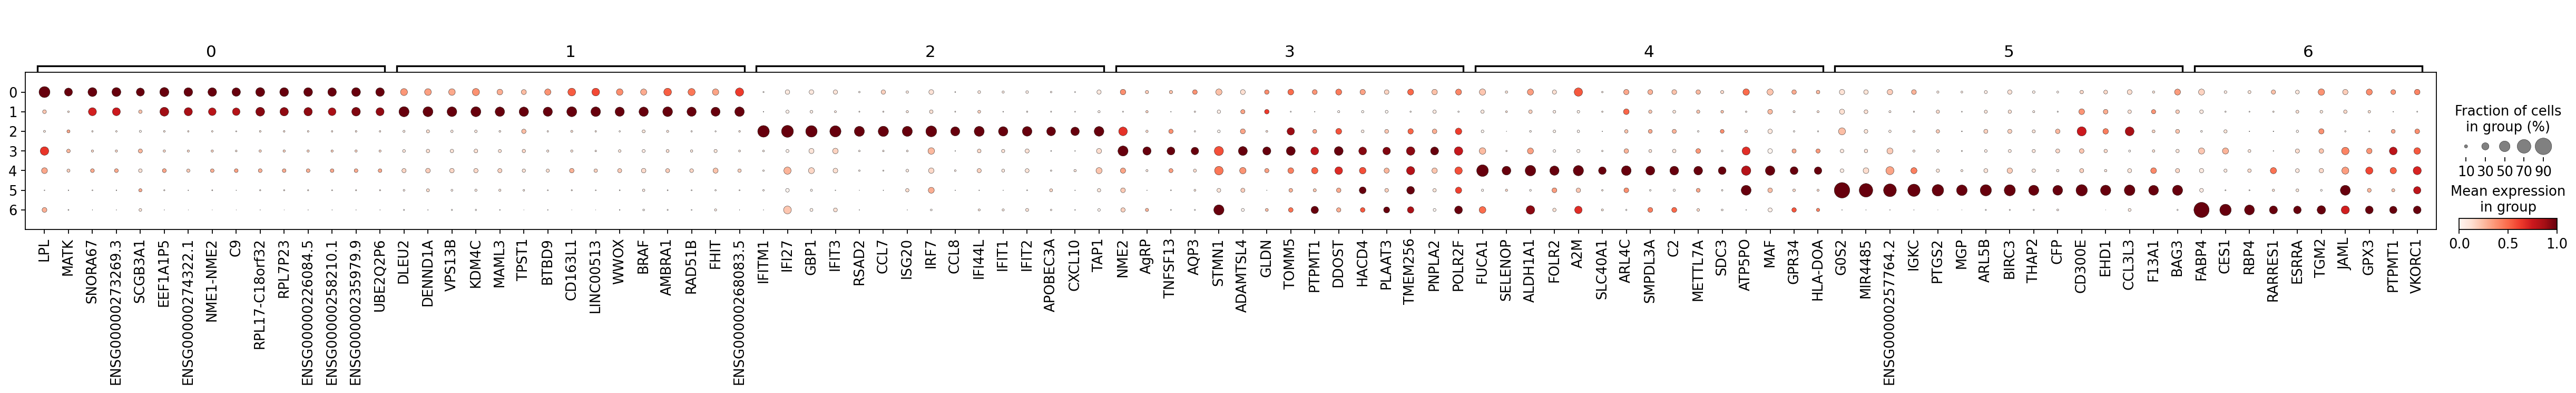

In [28]:
sc.pl.dotplot(
    adata_mdm_filt,
    groupby="leiden_0.3",
    var_names=degs_top15_per_cluster,
    dendrogram=False,
    standard_scale="var",
)

And with clusters split by study:

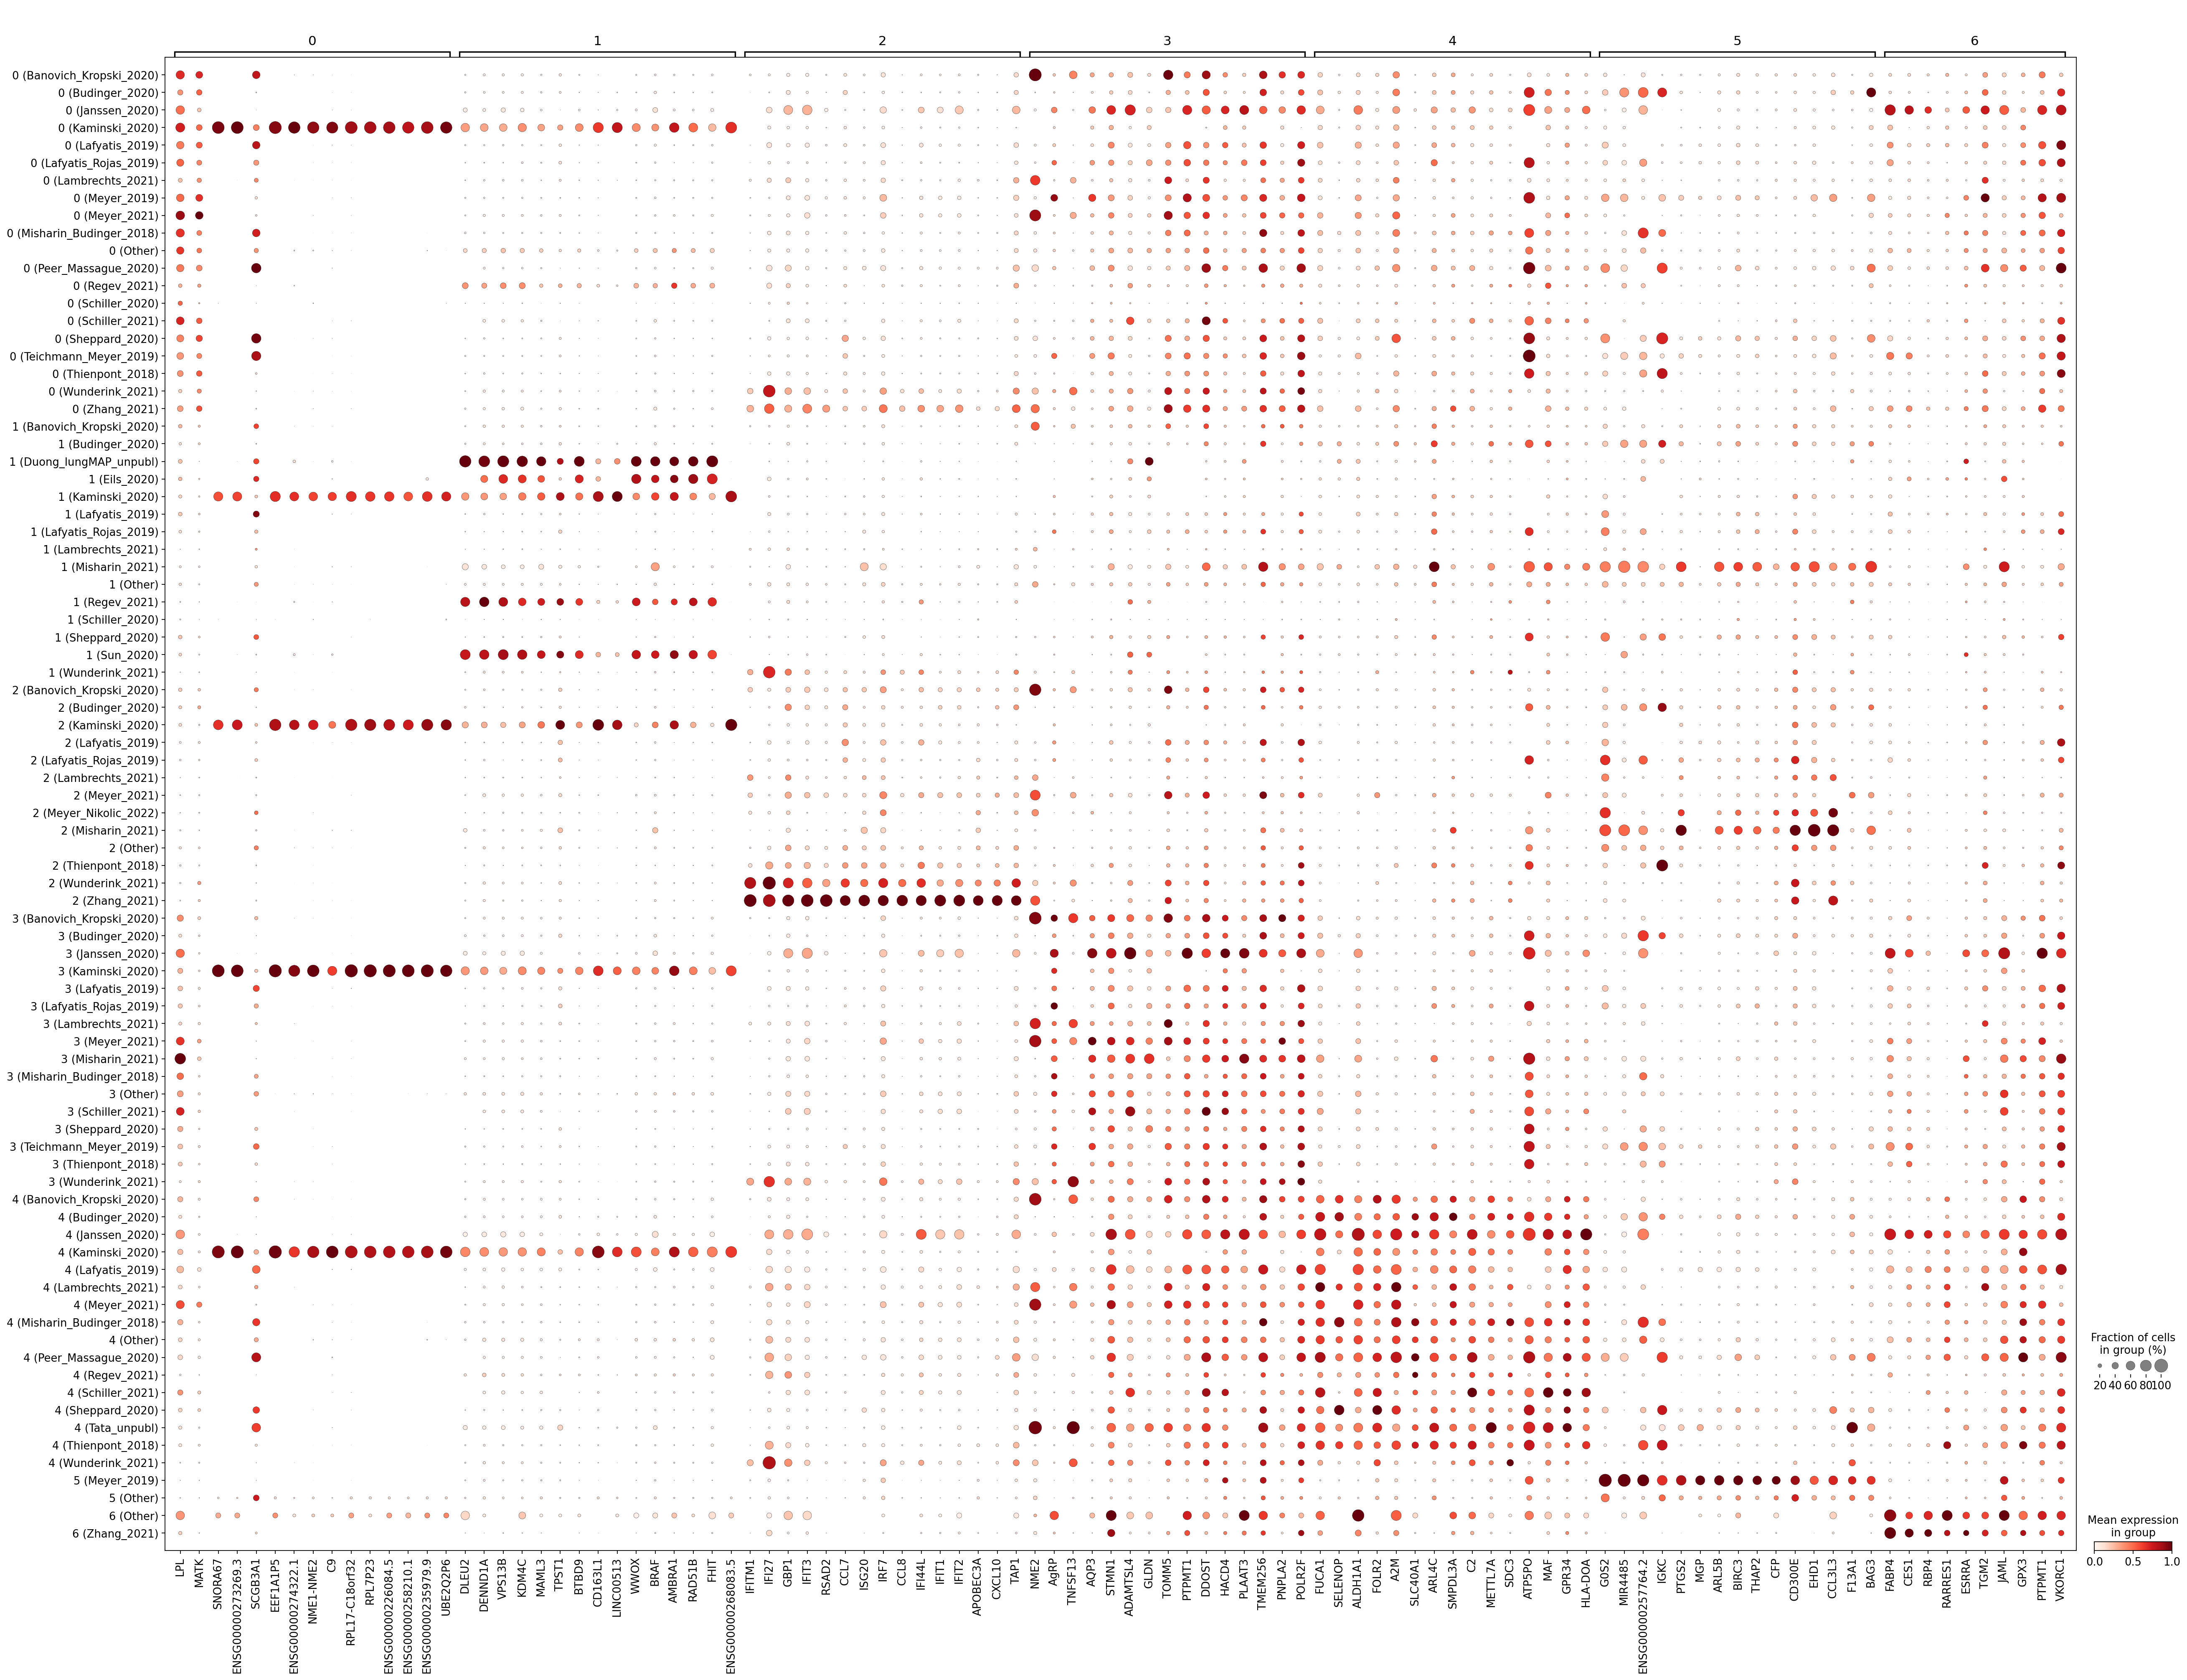

In [29]:
sc.pl.dotplot(
    adata_mdm_filt,
    groupby="leiden_0.3_study",
    var_names=degs_top15_per_cluster,
    dendrogram=False,
    standard_scale="var",
)

For each cluster, calculate the proportion of cells coming from the most "abundant" subject:

In [30]:
cl_subj_props = pd.crosstab(adata_mdm.obs["leiden_0.3"], adata_mdm.obs["subject_ID"])
cl_subj_props = cl_subj_props.divide(cl_subj_props.sum(axis=1), axis=0) * 100

In [31]:
for cl in cl_subj_props.index:
    print(
        f"Cluster {cl}, highest subject propostion:",
        round(cl_subj_props.loc[cl, :].sort_values(ascending=False)[0], 1),
    )

Cluster 0, highest subject propostion: 4.8
Cluster 1, highest subject propostion: 8.1
Cluster 2, highest subject propostion: 15.2
Cluster 3, highest subject propostion: 7.8
Cluster 4, highest subject propostion: 28.8
Cluster 5, highest subject propostion: 71.5
Cluster 6, highest subject propostion: 85.7


Based on differentially expressed genes and correspondence with previously published work, we name the clusters as follows:

In [32]:
cluster_naming = {
    "0": "profibrotic SPP1 high (0)",
    "1": "MdMs (1)",
    "2": "inflammatory CCL2 high (2)",
    "3": "MARCO high (3)",
    "4": "inflammatory C1QA high (4)",
    "5": "early (single subject) (5)",
    "6": "alveolar mph (single subject) (6)",
}
adata_mdm_filt.obs["leiden_named"] = adata_mdm.obs["leiden_0.3"].map(cluster_naming)

Selection of final markers, excluding single-subject cluster 5 and 6. Also note that we add general MDM markers, and no extra markers for cluster 1, as this cluster did not show consistent and unique marker expression across studies.

In [33]:
final_markers_all = {
    "MdMs": ["ITGAM", "SOD2", "MAFB", "CSF1R"],
    cluster_naming["2"]: [
        "CCL2",
        "IL1RN",
        "C15orf48",
        "S100A12",
    ],  # MoAM2
    cluster_naming["4"]: [
        "CCL18",
        "C1QA",
        "TREM2",
        "PLTP",
        "CD4",
        "IL18",
        "TMEM176A",
        "AKR1B1",
    ],  # MoAM3
    cluster_naming["3"]: ["FBP1", "MCEMP1", "MARCO"],  # MoAM4
    cluster_naming["0"]: [
        "SPP1",
        "MMP9",
        "CHI3L1",
        "CHIT1",
        "LPL",
        "FDX1",
    ],
}

Order categories based on early to late MDM stage (with 6 and 1 added at the end):

In [34]:
adata_mdm_filt.obs.leiden_named = (
    adata_mdm_filt.obs.leiden_named.cat.reorder_categories(
        [
            cluster_naming["5"],
            cluster_naming["2"],
            cluster_naming["4"],
            cluster_naming["3"],
            cluster_naming["0"],
            cluster_naming["6"],
            cluster_naming["1"],
        ]
    )
)

Remove cluster 5 and 6 for plots:

In [35]:
adata_mdm_no5_and_6 = adata_mdm_filt[
    adata_mdm_filt.obs["leiden_0.3"].isin(["0", "1", "2", "3", "4"]), :
].copy()

Plot final markers:

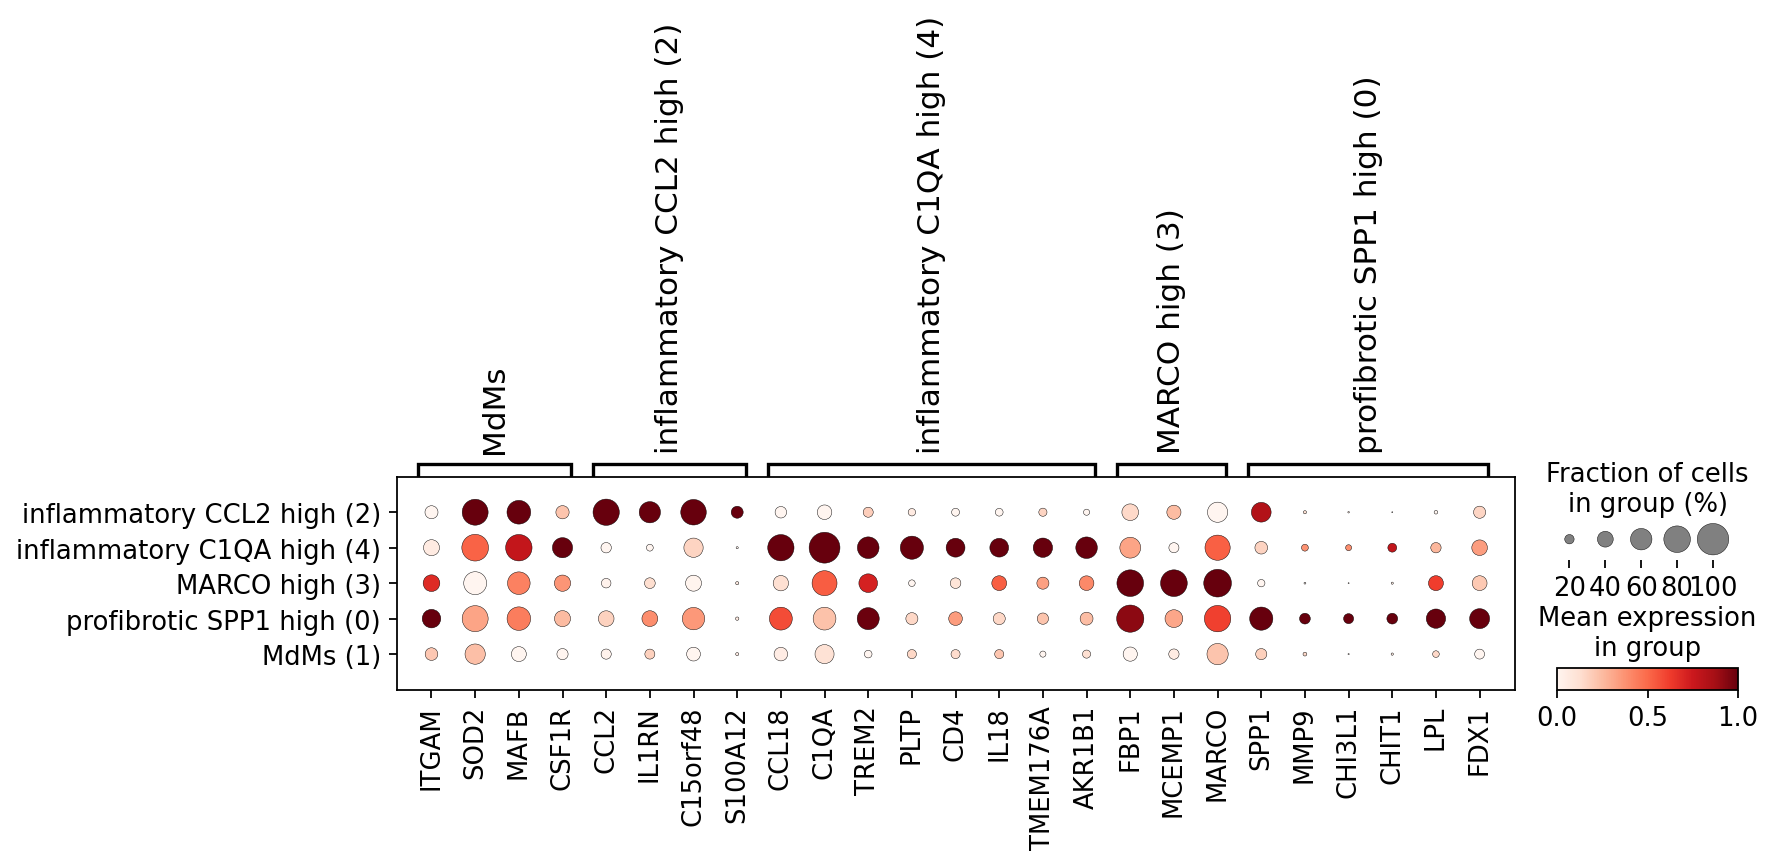

In [49]:
FIGURES["6k_MdM_markers"] = sc.pl.dotplot(
    adata_mdm_no5_and_6,
    var_names=final_markers_all,
    groupby="leiden_named",
    standard_scale="var",
    return_fig=True,
)
FIGURES["6k_MdM_markers"].show()

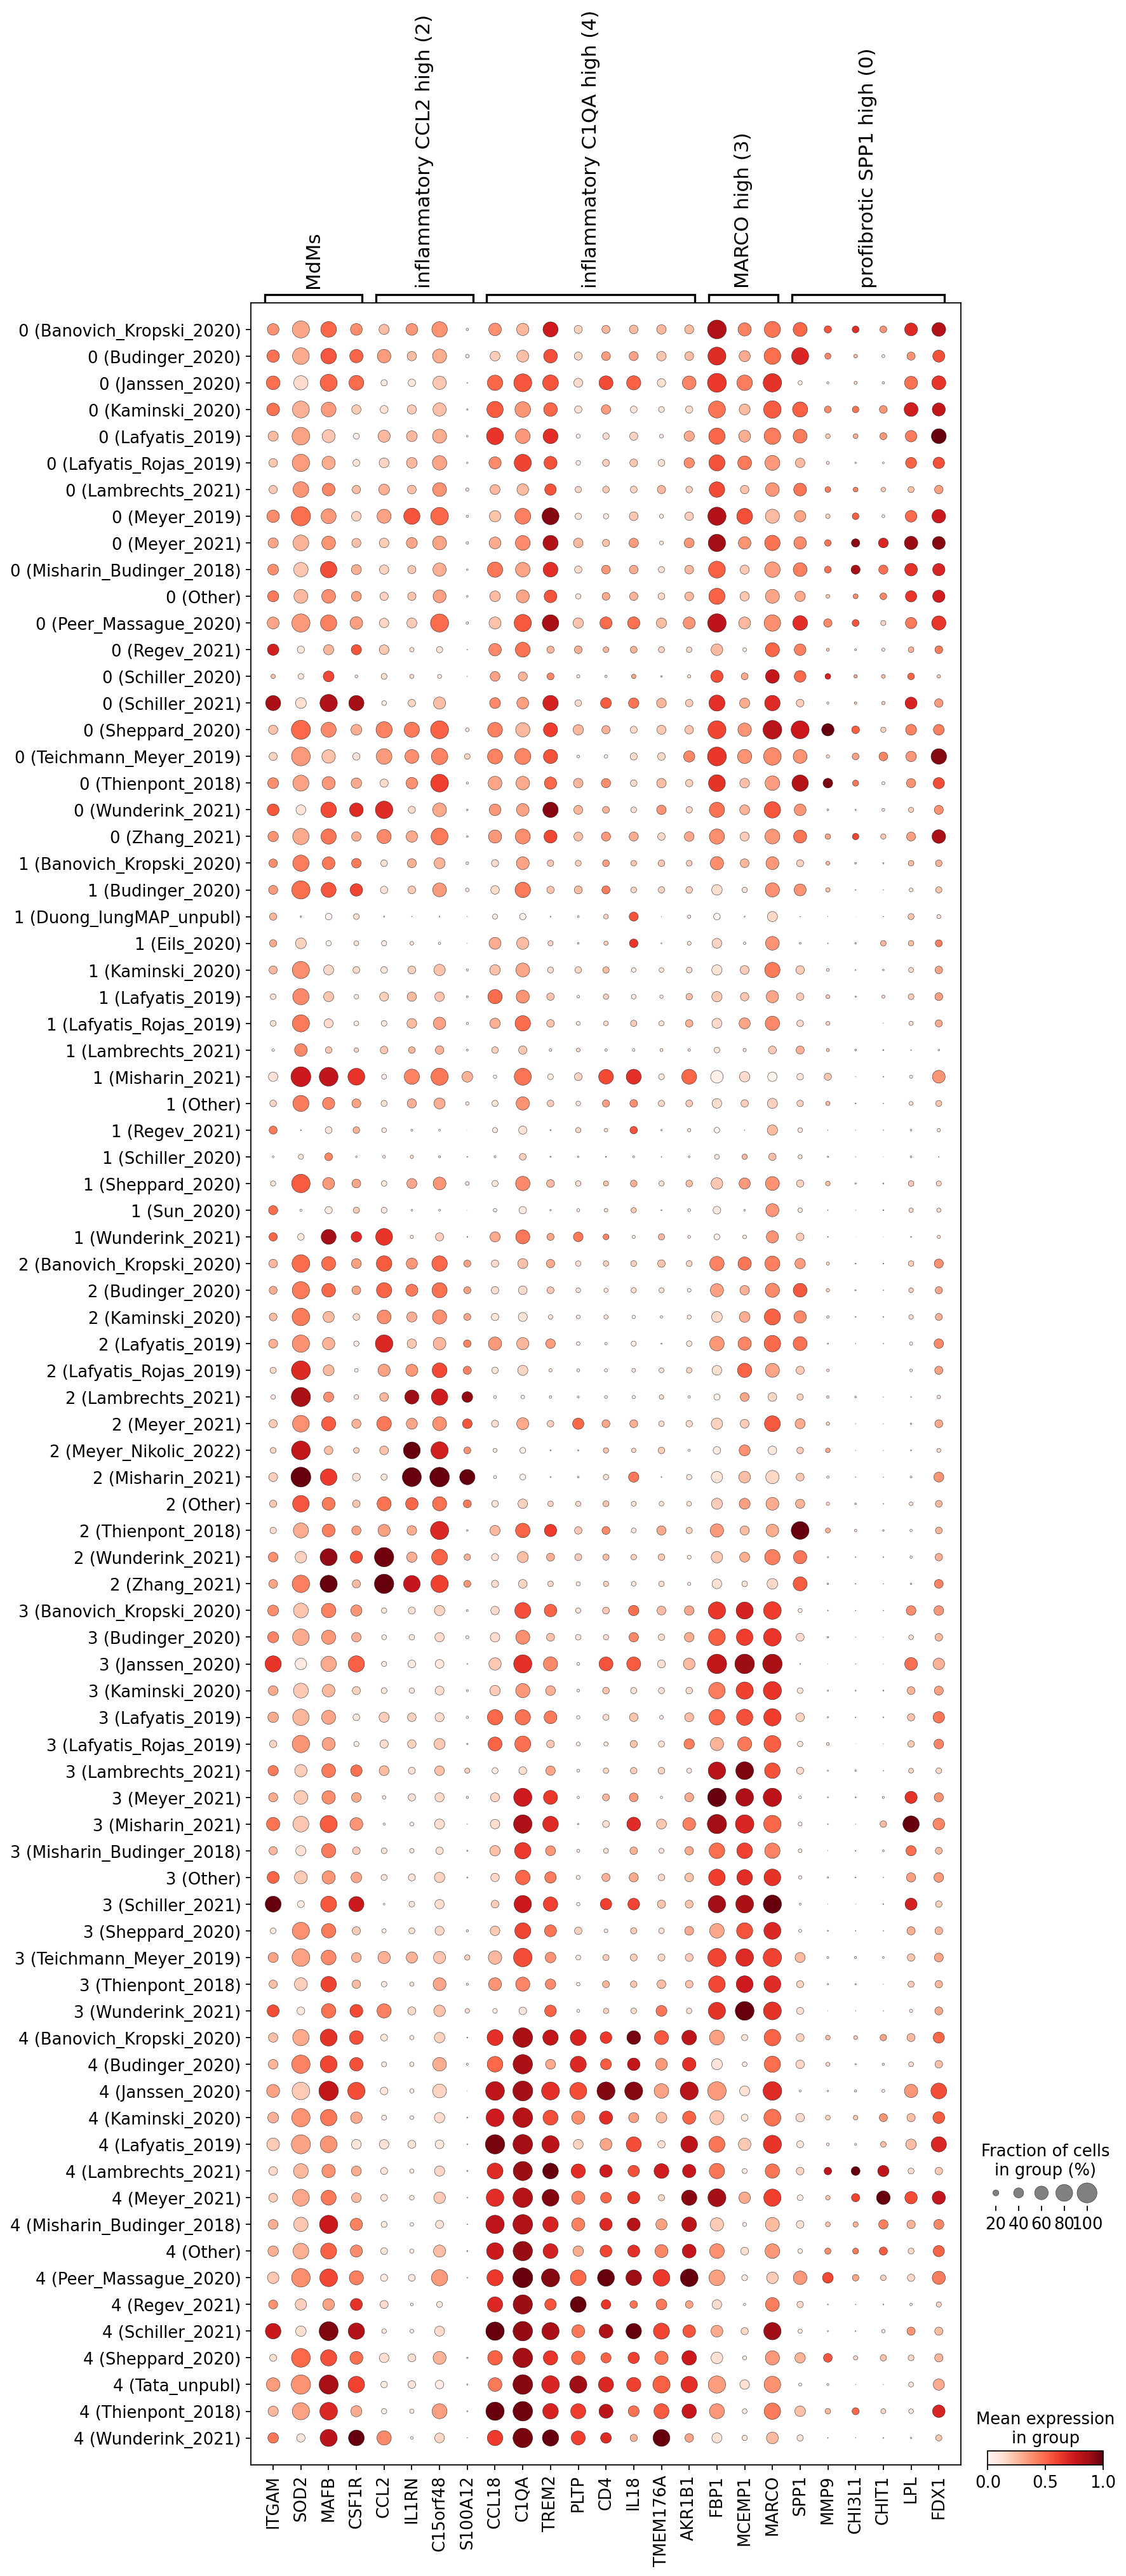

In [37]:
FIGURES["ED10f_MdM_markers_per_study"] = sc.pl.dotplot(
    adata_mdm_no5_and_6,
    var_names=final_markers_all,
    groupby="leiden_0.3_study",
    standard_scale="var",
    return_fig=True,
)
FIGURES["ED10f_MdM_markers_per_study"].show()

**UMAPs and barplots**

First, hiding cluster 4 label because it is divided into two in the UMAP and that makes the centroid land on another cluster.

In [38]:
cluster_hider = {cond: cond for cond in adata_mdm.obs["leiden_0.3"].unique()}
cluster_hider["4"] = ""
adata_mdm.obs["leiden_0.3_x4"] = adata_mdm.obs["leiden_0.3"].map(cluster_hider)
pd.crosstab(adata_mdm.obs["leiden_0.3_x4"], adata_mdm.obs["leiden_0.3"])

leiden_0.3         0      1      2      3      4     5    6
leiden_0.3_x4                                              
0              64915      0      0      0      0     0    0
1                  0  47539      0      0      0     0    0
2                  0      0  32027      0      0     0    0
3                  0      0      0  31097      0     0    0
                   0      0      0      0  25267     0    0
5                  0      0      0      0      0  1998    0
6                  0      0      0      0      0     0  307

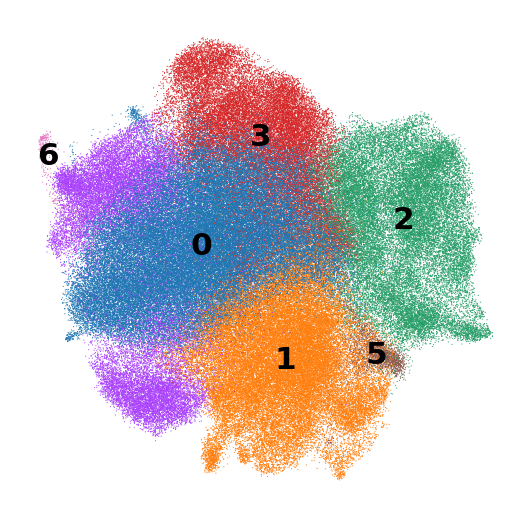

In [39]:
FIGURES["6i_MdM_umap"] = sc.pl.umap(
    adata_mdm,
    color="leiden_0.3_x4",
    size=1,
    frameon=False,
    wspace=0.6,
    title="",
    legend_loc="on data",
    return_fig=True,
)
FIGURES["6i_MdM_umap"].show()

UMAP with highlighted mapped data

In [40]:
path_celltype_colors = "../../supporting_files/celltype_structure_and_colors/manual_anns_grouped_order_and_colors.csv"
emb_full_path = "../../data/HLCA_extended/HLCA_extended/HLCA_extended_scarches_emb.h5ad"

In [41]:
celltype_colors = pd.read_csv(path_celltype_colors, index_col=0)
emb_full = sc.read_h5ad(emb_full_path)

In [42]:
emb_full.obs["mdms"] = "Other"
emb_full.obs.loc[adata_mdm.obs.index, "mdms"] = "Monocyte-derived macrophages"

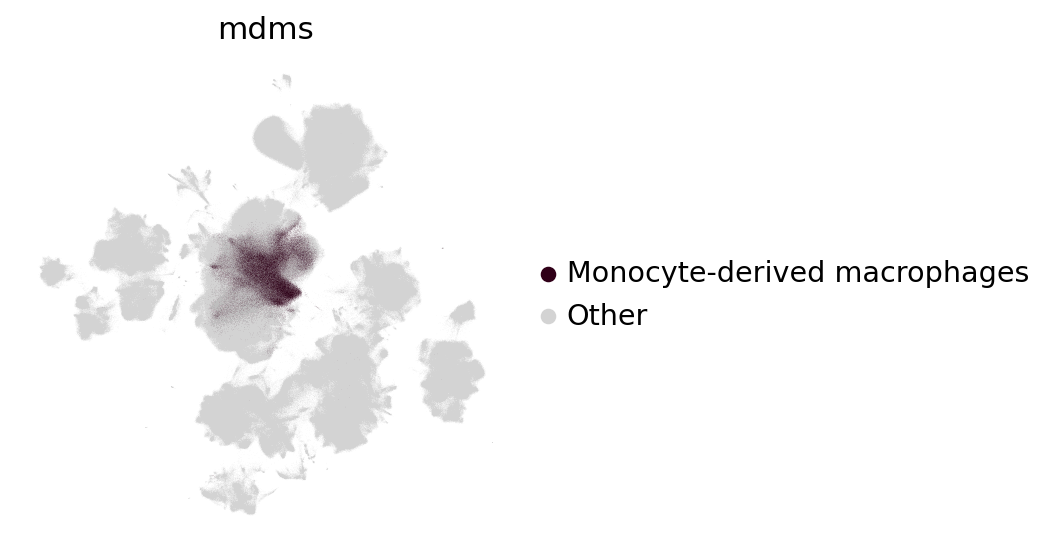

In [43]:
FIGURES["6i_MdM_umap_full"] = sc.pl.umap(
    emb_full,
    color="mdms",
    palette={
        "Other": "lightgrey",
        "Monocyte-derived macrophages": celltype_colors.loc[
            "Monocyte-derived Mph", "color"
        ],
    },
    frameon=False,
    return_fig=True,
)
FIGURES["6i_MdM_umap_full"].show()

Barplots

In [44]:
i = "leiden_0.3"
barplots = {
    "6j_MdM_barplot_disease": {"y": "condition_merged"},
    "ED10e_MdM_barplot_sample": {"y": "sample_type"},
    "ED10g_MdM_barplot_covid19_disease_study": {
        "y": "condition_merged_study",
        "filter": ["condition_merged", "COVID-19"],
    },
    "ED10h_MdM_barplot_covid19_sampling": {
        "y": "sample_type",
        "filter": ["condition_merged", "COVID-19"],
    },
    "ED10j_MdM_barplot_ipf_disease_study": {
        "y": "condition_merged_study",
        "filter": ["condition_merged", "IPF"],
    },
}

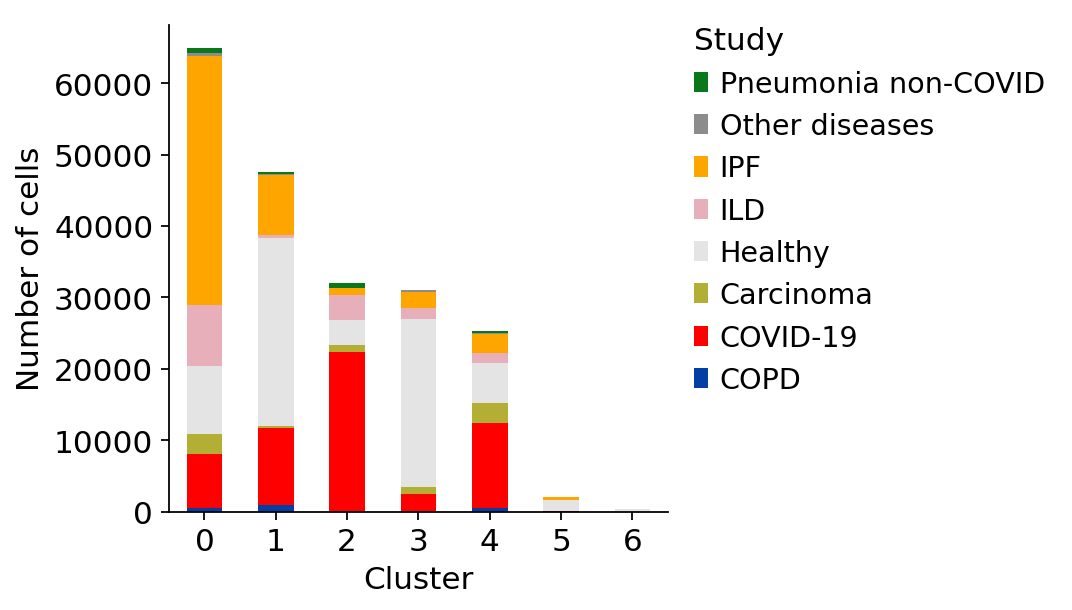

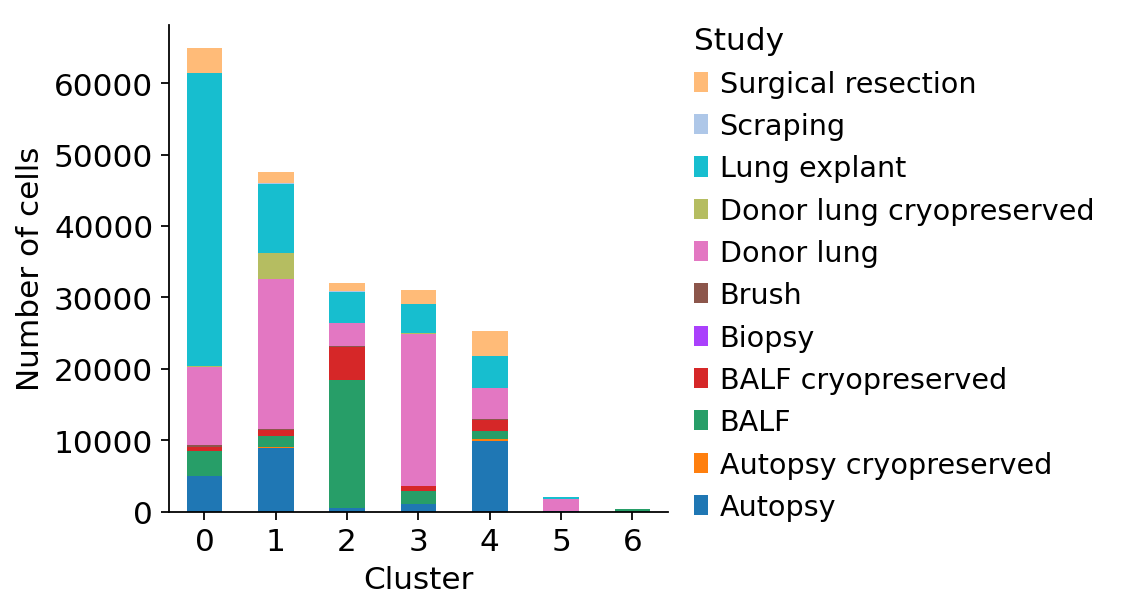

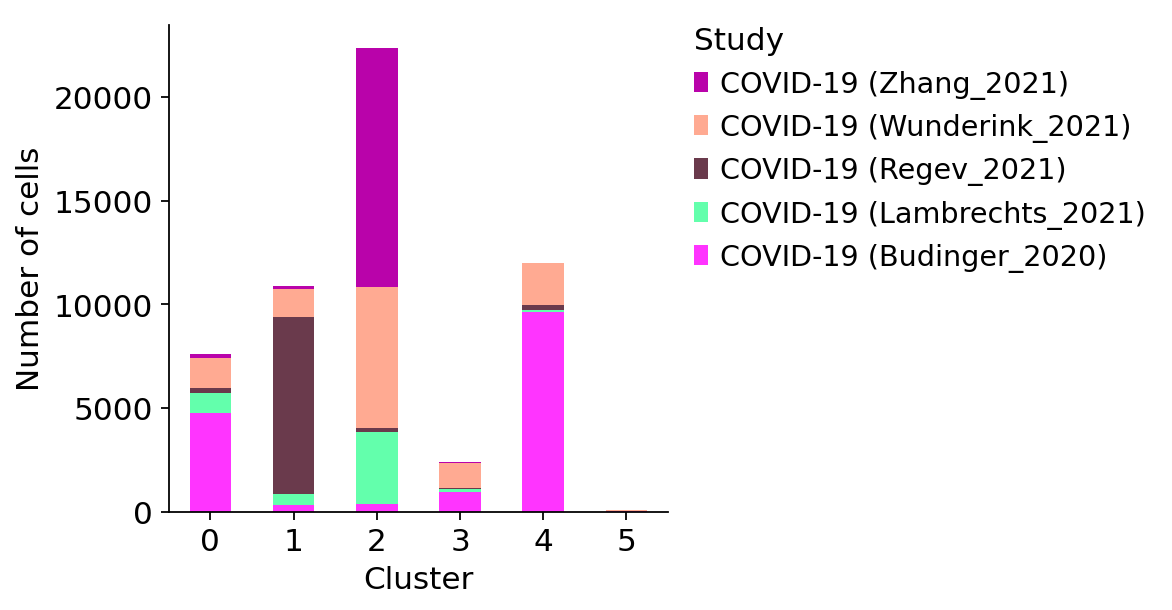

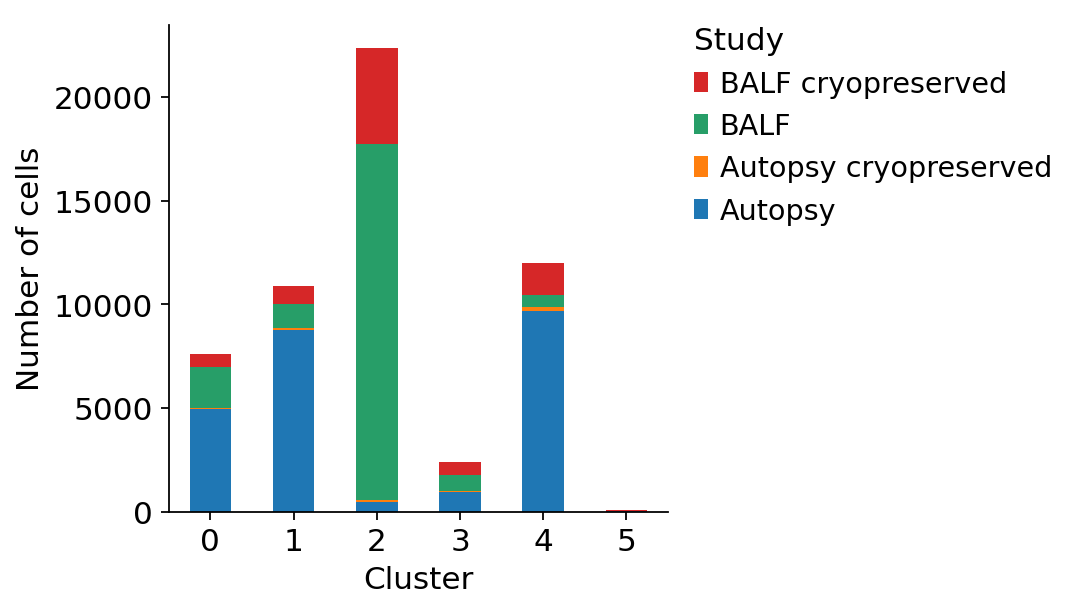

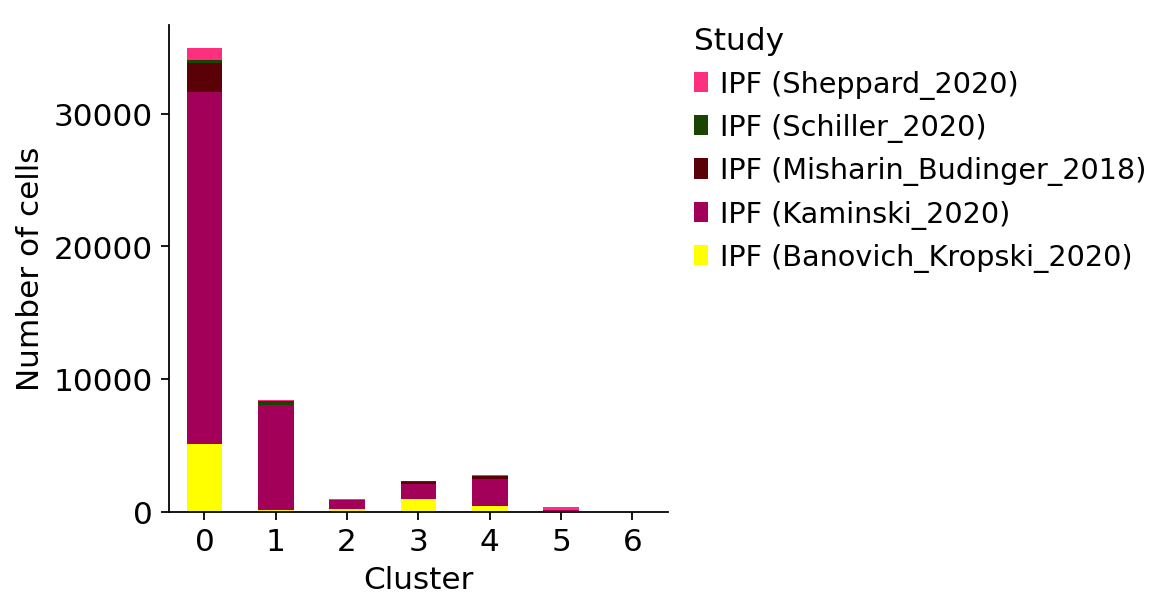

In [45]:
for bp_i in barplots.keys():
    j = barplots[bp_i]["y"]
    df = adata_mdm_filt.obs.copy()
    if "filter" in barplots[bp_i].keys():
        filts = barplots[bp_i]["filter"]
        df = df.loc[df[filts[0]].isin(filts[1:]), :].copy()
    df_plot = pd.crosstab(df[i], df[j])
    fig, ax = plt.subplots()
    df_plot.plot(
        kind="bar", stacked=True, legend=False, ax=ax, color=condition_colors[j]
    )

    handles, labels = ax.get_legend_handles_labels()
    leg = plt.legend(
        handles[::-1],
        labels[::-1],
        bbox_to_anchor=(1, 1.05, 0, 0),
        ncol=1,
        frameon=False,
        title="Study",
    )
    leg._legend_box.align = "left"
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.xlabel("Cluster")
    plt.ylabel("Number of cells")
    ax.grid(False)
    plt.xticks(rotation=0)
    FIGURES[bp_i] = fig
    plt.show()

## Store results:

Store filtered differentially expressed genes per cluster:

In [46]:
for cluster in range(0, 7):
    deg_df = degs_per_cluster[cluster].set_index("names")
    deg_df.to_csv(
        os.path.join(
            dir_differential_expr_analysis, f"DEGs_MDM_cluster_{cluster}_filtered.csv"
        )
    )

Store figures:

In [50]:
for figname, fig in FIGURES.items():
    print("Storing", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

Storing ED10f_MdM_markers_per_study
Storing 6i_MdM_umap
Storing 6i_MdM_umap_full
Storing 6j_MdM_barplot_disease
Storing ED10e_MdM_barplot_sample
Storing ED10g_MdM_barplot_covid19_disease_study
Storing ED10h_MdM_barplot_covid19_sampling
Storing ED10j_MdM_barplot_ipf_disease_study
Storing 6k_MdM_markers


Done